In [1]:
import numpy as np
from glm import BernoulliGLM, BernoulliGLMwReg, BernoulliGLMPyTorch
import pandas as pd

from utils import *

import torch
import torch.nn as nn
import torch.distributions as dist

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
sim_data_path = './sim/save/pagsim_w_stimuli/'
brain_regions = [
                'VMH',
                'ACC',
                'IC',
                'SC',
                'PMD'
                ]
presyn_binned = np.load(sim_data_path+'presyn_binned.npy')
presyn_smooth = np.load(sim_data_path+'presyn_exp_smooth.npy')

# load actual connecticity: shape (n_brain_region * n_PAG * n_connections)
conns = np.concatenate([np.nan_to_num(np.load(f'{sim_data_path}connectivity_{brain_region.lower()}2pag.npy'),  nan=0.0).T[None,:] * 1e9 for brain_region in brain_regions])

### single PAG cell with no exponential prefiltering on inputs

In [3]:
n_PAG_to_use = 1 # specify how many PAG neurons to learn
sim_data_path = './sim/save/pagsim_w_stimuli/'
pre_convolve_spikes = False
bin_size = 0.001

n_input_neurons, n_bins = presyn_binned.shape
_total_length = n_bins / 1000

pag_df = extract_sim_as_df(sim_data_path, 'PAG')
pag_timings = extract_timings(pag_df, 'PAG')
pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[:n_PAG_to_use]
print(f'Average PAG firing rate: {np.sum(pag_binned_spikes) / pag_binned_spikes.shape[0] / _total_length} Hz.')

2023-12-04 13:58:54.847 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Average PAG firing rate: 44.35333333333333 Hz.


In [4]:
# construct input and output matrices
train_start = 0
train_end = 300
test_start = 300
test_end = 400
# for pag_stim_w_stimuli, external pulses are delivered from 40 mins to 60 mins, 10 secs each, lasting 1 sec
train_bins = int((train_end - train_start) / bin_size)
test_bins = int((test_end - test_start) / bin_size)

X_train, X_test = np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * train_bins)), np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * test_bins))
y_train, y_test = np.zeros((1, train_bins * n_PAG_to_use)), np.zeros((1, test_bins * n_PAG_to_use))

print(X_train.shape)
for n in range(n_PAG_to_use):
    X_train[n_input_neurons*n:n_input_neurons*(n+1), n * train_bins: (n+1) * train_bins] = presyn_binned[:, int(train_start/bin_size):int(train_end/bin_size)] # chunks of n_neurons * train_set_bin_size
    X_test[n_input_neurons*n:n_input_neurons*(n+1), n * test_bins :(n+1) * test_bins] = presyn_binned[:, int(test_start/bin_size):int(test_end/bin_size)]
    
    y_train[:, n * train_bins: (n+1)* train_bins] = pag_binned_spikes[n, int(train_start/bin_size): int(train_end/bin_size)]
    y_test[:, n * test_bins: (n+1)* test_bins] = pag_binned_spikes[n, int(test_start/bin_size): int(test_end/bin_size)]
assert X_train.shape[1] == y_train.shape[1]
assert X_test.shape[1] == y_test.shape[1]

print('Number of PAG spikes in the training set: ', np.sum(y_train))
print('Number of PAG spikes in the test set: ', np.sum(y_test))

(320, 300000)
Number of PAG spikes in the training set:  13379.0
Number of PAG spikes in the test set:  4301.0


In [4]:
glm = BernoulliGLMPyTorch(
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    reg_params=1,
    ).to(device)

# glm.fit(X_train.T, y_train.T, n_iter=5000, lr=1e-3, verbose=1, decay=0.9998)
# glm.load_best_params()
# torch.save(glm.state_dict(), f'{sim_data_path}sing_bin_reg1.pth')

glm._load_state_dict(torch.load(f'{sim_data_path}sing_bin_reg1.pth'))

#### Analysis

In [30]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)

Learned bias: [-1.7909154]


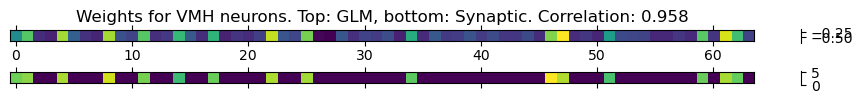

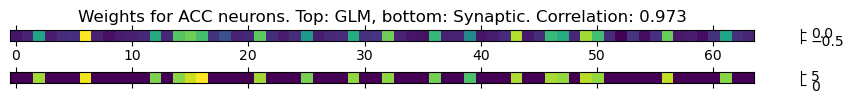

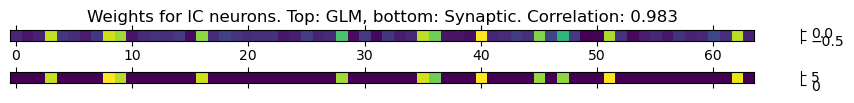

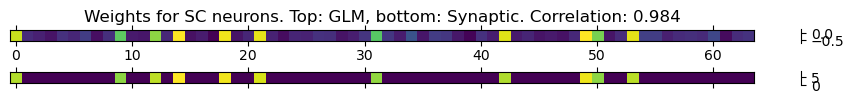

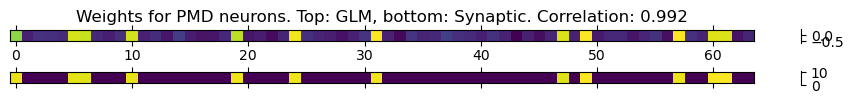

In [41]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_neuron_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_neuron_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])

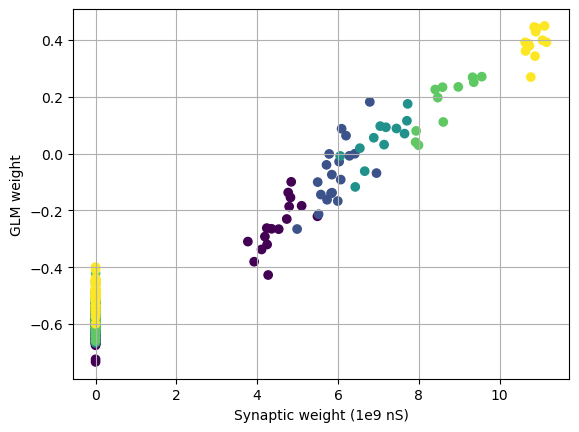

In [61]:
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.neuron_group_idx)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

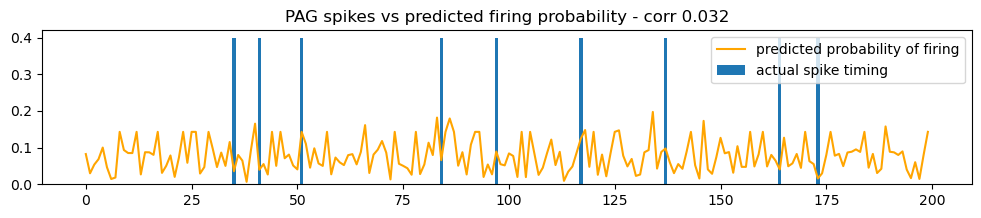

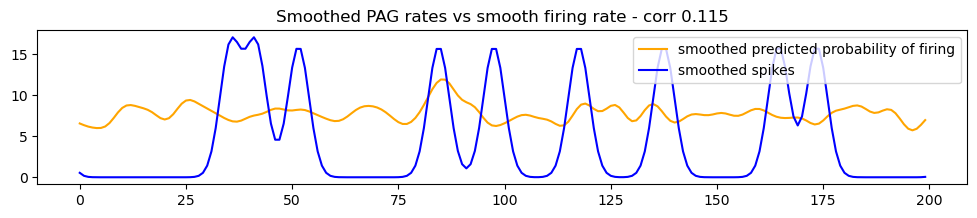

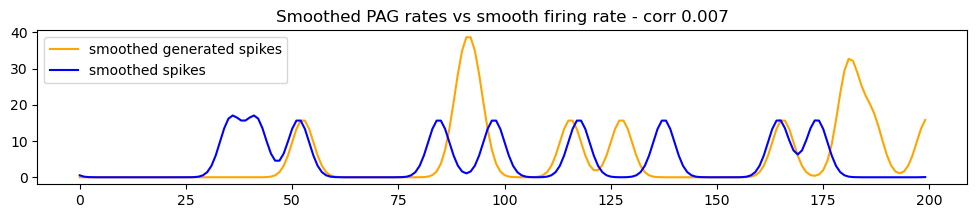

In [102]:
# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    
_range = 200 #ms
_random_start = np.random.randint(y_test.shape[1]-_range)

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

### single PAG cell with exponential prefiltering on inputs - this is to understand the contribution of the exponential prefiltering

In [3]:
n_PAG_to_use = 1
pre_convolve_spikes = True
bin_size = 0.001
brain_regions = [
                'VMH',
                'ACC',
                'IC',
                'SC',
                'PMD'
                ]

presyn_binned = np.load(sim_data_path+'presyn_binned.npy')
if pre_convolve_spikes:
    presyn_smooth = np.load(sim_data_path+'presyn_exp_smooth.npy')
    
n_input_neurons, n_bins = presyn_binned.shape
_total_length = n_bins / 1000

pag_df = extract_sim_as_df(sim_data_path, 'PAG')
pag_timings = extract_timings(pag_df, 'PAG')
if n_PAG_to_use == 1:
    pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[:n_PAG_to_use]
else:
    pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[:n_PAG_to_use]
print(f'Average PAG firing rate: {np.sum(pag_binned_spikes) / pag_binned_spikes.shape[0] / _total_length} Hz.')

2023-12-04 13:59:59.459 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Average PAG firing rate: 44.35333333333333 Hz.


In [4]:
# construct input and output matrices
train_start = 0
train_end = 300
test_start = 300
test_end = 400
# for pag_stim_w_stimuli, external pulses are delivered from 40 mins to 60 mins, 10 secs each, lasting 1 sec
train_bins = int((train_end - train_start) / bin_size)
test_bins = int((test_end - test_start) / bin_size)

X_train, X_test = np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * train_bins)), np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * test_bins))
y_train, y_test = np.zeros((1, train_bins * n_PAG_to_use)), np.zeros((1, test_bins * n_PAG_to_use))

print(X_train.shape)
for n in range(n_PAG_to_use):
    X_train[n_input_neurons*n:n_input_neurons*(n+1), n * train_bins: (n+1) * train_bins] = presyn_smooth[:, int(train_start/bin_size):int(train_end/bin_size)] # chunks of n_neurons * train_set_bin_size
    X_test[n_input_neurons*n:n_input_neurons*(n+1), n * test_bins :(n+1) * test_bins] = presyn_smooth[:, int(test_start/bin_size):int(test_end/bin_size)]
    
    y_train[:, n * train_bins: (n+1)* train_bins] = pag_binned_spikes[n, int(train_start/bin_size): int(train_end/bin_size)]
    y_test[:, n * test_bins: (n+1)* test_bins] = pag_binned_spikes[n, int(test_start/bin_size): int(test_end/bin_size)]
assert X_train.shape[1] == y_train.shape[1]
assert X_test.shape[1] == y_test.shape[1]

print('Number of PAG spikes in the training set: ', np.sum(y_train))
print('Number of PAG spikes in the test set: ', np.sum(y_test))

(320, 300000)
Number of PAG spikes in the training set:  13379.0
Number of PAG spikes in the test set:  4301.0


In [5]:
glm = BernoulliGLMPyTorch(
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    reg_params=1,
    ).to(device)

# glm.fit(X_train.T, y_train.T, n_iter=5000, lr=1e-3, verbose=1, decay=0.9998)
# glm.load_best_params()
# torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg1.pth')
glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg1.pth'))

#### Analysis

In [6]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)

Learned bias: [-0.7244827]


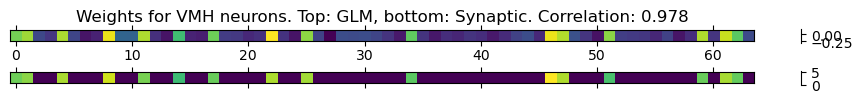

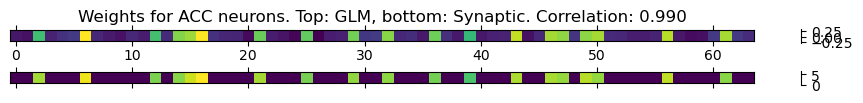

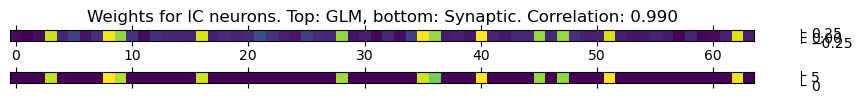

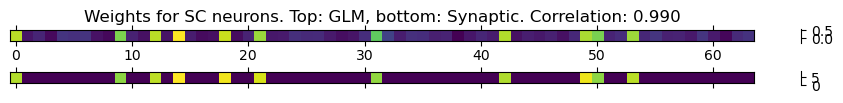

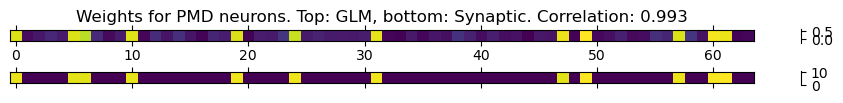

In [7]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_neuron_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_neuron_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])

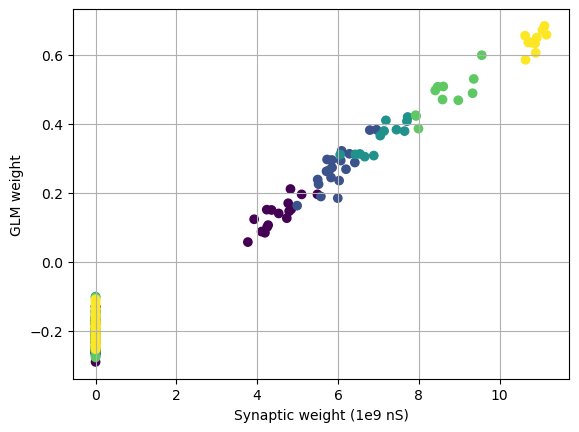

In [8]:
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.neuron_group_idx)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

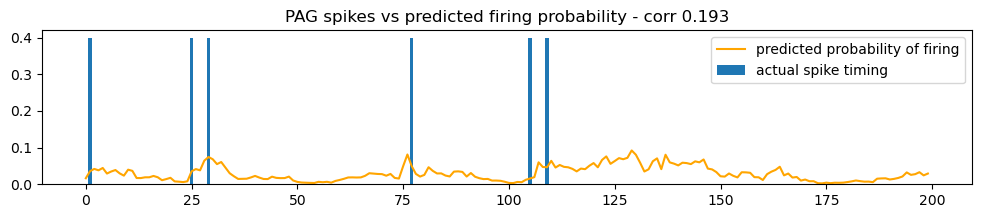

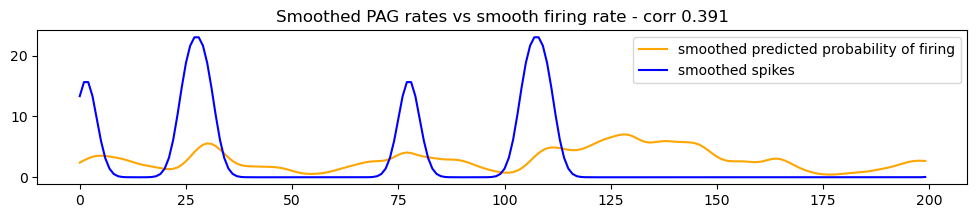

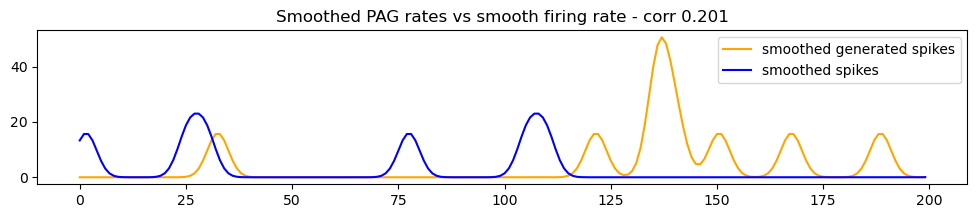

In [9]:
# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    
_range = 200 #ms
_random_start = np.random.randint(y_test.shape[1]-_range)

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

#### test for each of the 8 PAG cells respectively

2023-12-05 11:41:47.556 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Training on PAG # 0. Average PAG firing rate: 7.392222222222222e-05 Hz.


2023-12-05 11:41:47.794 | DEBUG    | glm:fit:269 - Training GLM with PyTorch. Initial log like: -204557.984375, inital loss: tensor([[204558.0625]])
2023-12-05 11:43:49.133 | DEBUG    | glm:fit:299 - Training complete with best log like: -52400.7734375, best loss: tensor([[52805.7656]]) at epoch 10000.


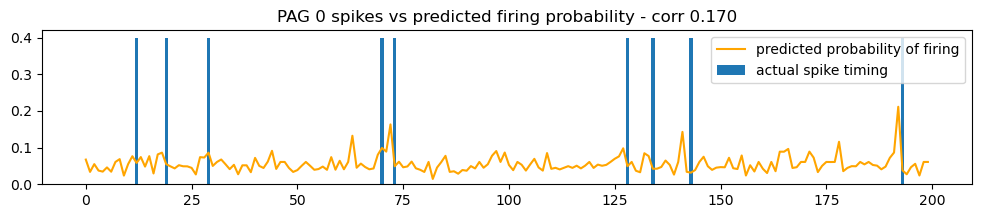

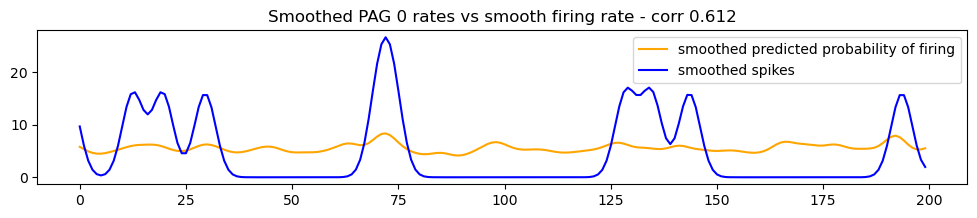

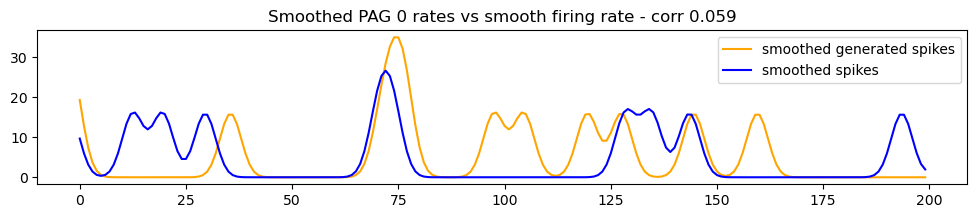

2023-12-05 11:43:51.026 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Training on PAG # 1. Average PAG firing rate: 8.395833333333333e-05 Hz.


2023-12-05 11:43:51.240 | DEBUG    | glm:fit:269 - Training GLM with PyTorch. Initial log like: -203731.53125, inital loss: tensor([[203731.5781]])
2023-12-05 11:45:51.541 | DEBUG    | glm:fit:299 - Training complete with best log like: -56646.6640625, best loss: tensor([[57091.1172]]) at epoch 10000.


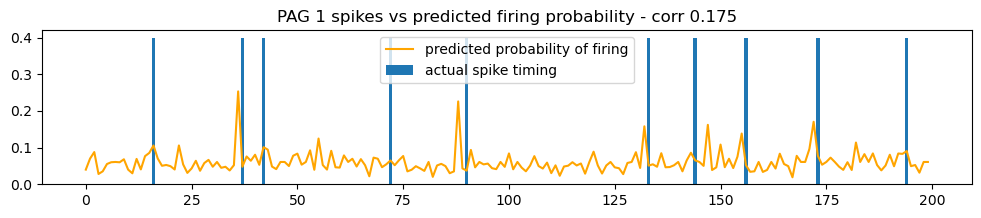

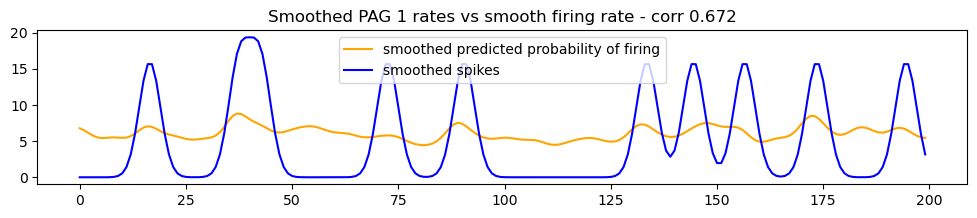

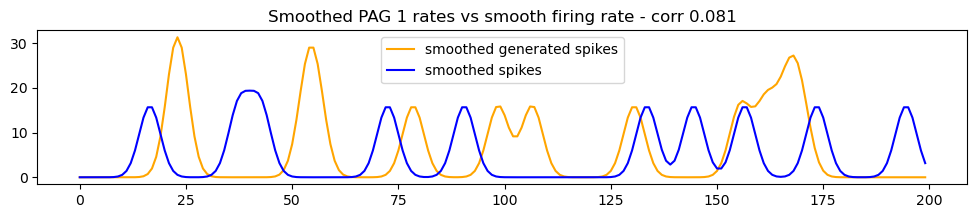

2023-12-05 11:45:53.340 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Training on PAG # 2. Average PAG firing rate: 5.250555555555556e-05 Hz.


2023-12-05 11:45:53.560 | DEBUG    | glm:fit:269 - Training GLM with PyTorch. Initial log like: -214634.90625, inital loss: tensor([[214634.9688]])
2023-12-05 11:47:56.576 | DEBUG    | glm:fit:299 - Training complete with best log like: -41744.3203125, best loss: tensor([[42068.2500]]) at epoch 10000.


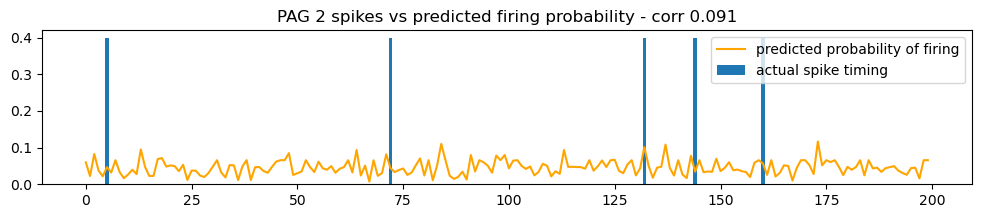

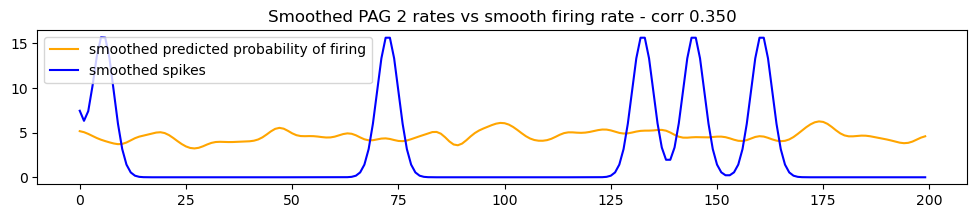

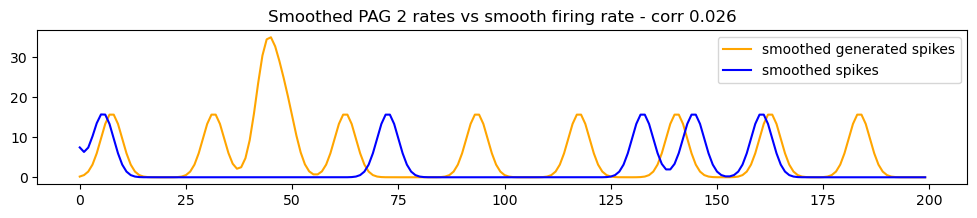

2023-12-05 11:47:58.198 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Training on PAG # 3. Average PAG firing rate: 8.540833333333333e-05 Hz.


2023-12-05 11:47:58.430 | DEBUG    | glm:fit:269 - Training GLM with PyTorch. Initial log like: -212518.46875, inital loss: tensor([[212518.5469]])
2023-12-05 11:49:58.375 | DEBUG    | glm:fit:299 - Training complete with best log like: -57781.140625, best loss: tensor([[58195.5781]]) at epoch 10000.


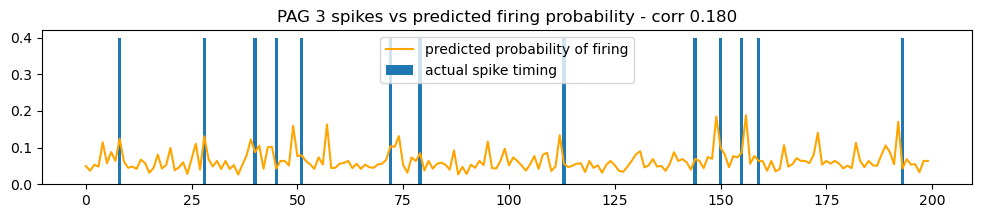

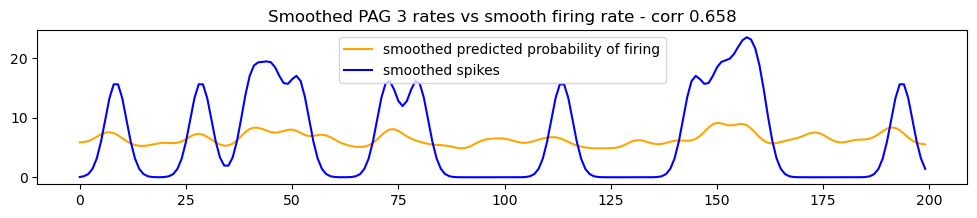

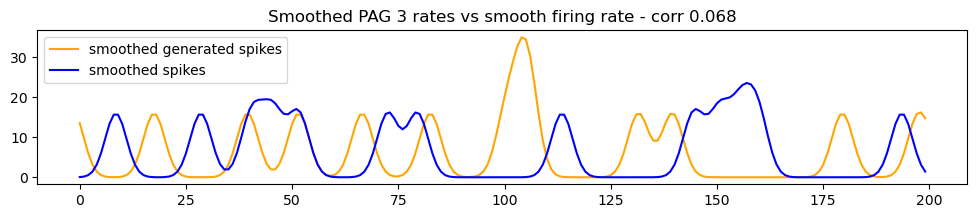

2023-12-05 11:50:00.146 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Training on PAG # 4. Average PAG firing rate: 5.676388888888889e-05 Hz.


2023-12-05 11:50:00.373 | DEBUG    | glm:fit:269 - Training GLM with PyTorch. Initial log like: -214720.9375, inital loss: tensor([[214720.9844]])
2023-12-05 11:52:00.657 | DEBUG    | glm:fit:299 - Training complete with best log like: -44094.375, best loss: tensor([[44419.1562]]) at epoch 10000.


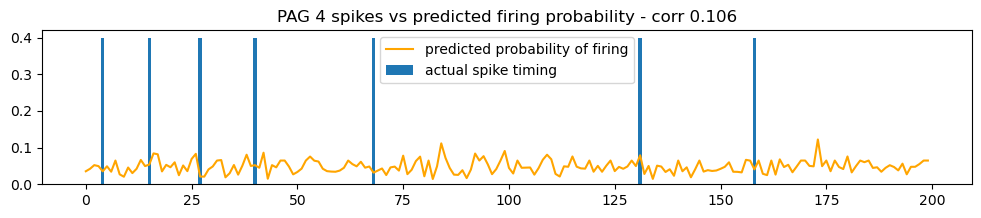

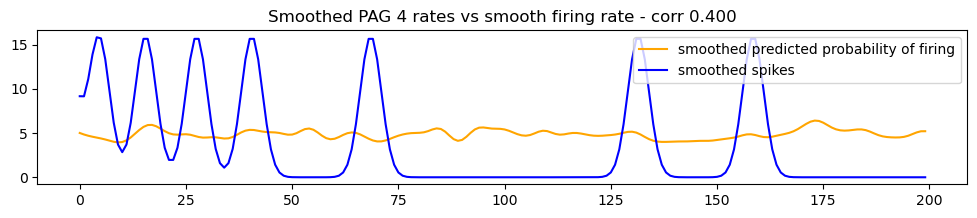

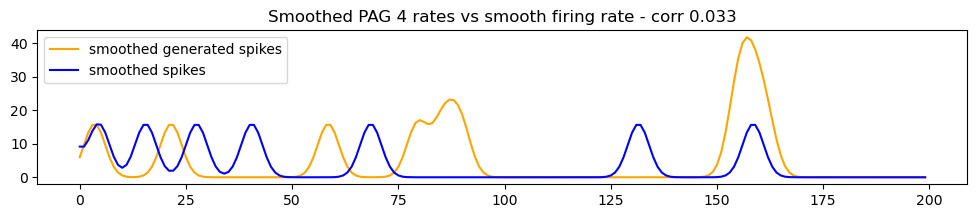

2023-12-05 11:52:02.382 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Training on PAG # 5. Average PAG firing rate: 7.417222222222223e-05 Hz.


2023-12-05 11:52:02.598 | DEBUG    | glm:fit:269 - Training GLM with PyTorch. Initial log like: -206808.59375, inital loss: tensor([[206808.6562]])
2023-12-05 11:54:16.127 | DEBUG    | glm:fit:299 - Training complete with best log like: -52331.1171875, best loss: tensor([[52722.3867]]) at epoch 10000.


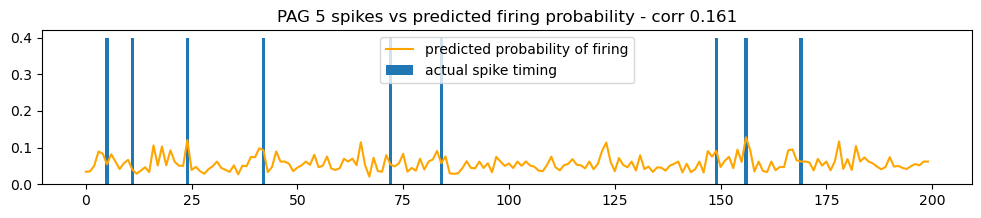

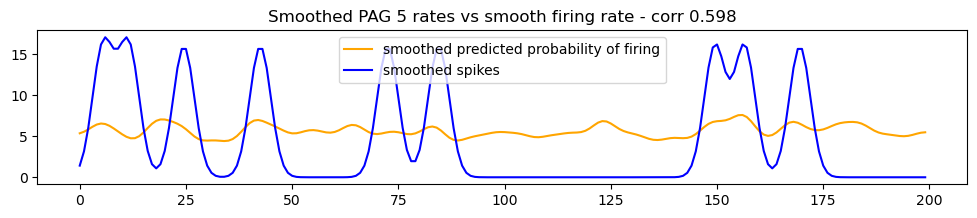

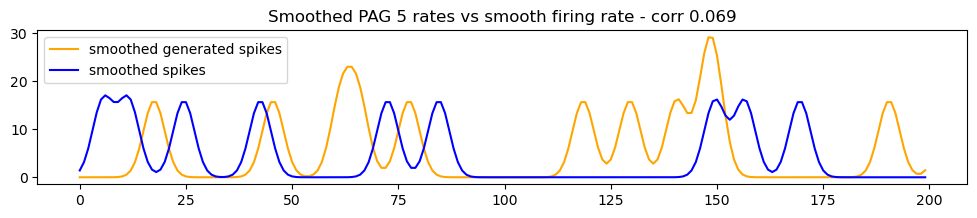

2023-12-05 11:54:18.328 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Training on PAG # 6. Average PAG firing rate: 0.00011645277777777777 Hz.


2023-12-05 11:54:18.558 | DEBUG    | glm:fit:269 - Training GLM with PyTorch. Initial log like: -212032.53125, inital loss: tensor([[212032.6094]])
2023-12-05 11:56:32.698 | DEBUG    | glm:fit:299 - Training complete with best log like: -70734.5078125, best loss: tensor([[71274.9766]]) at epoch 10000.


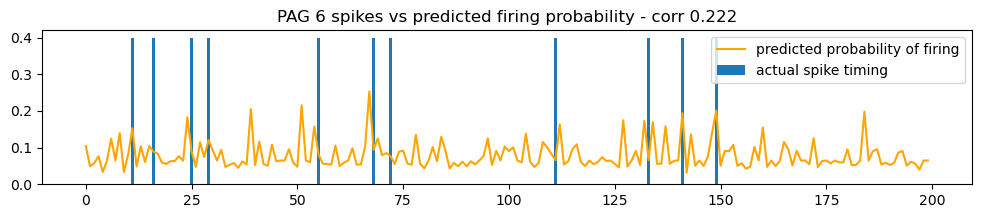

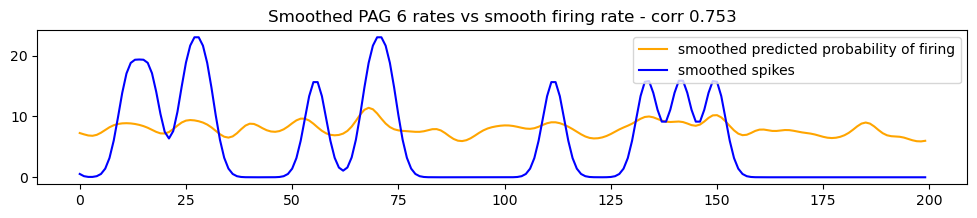

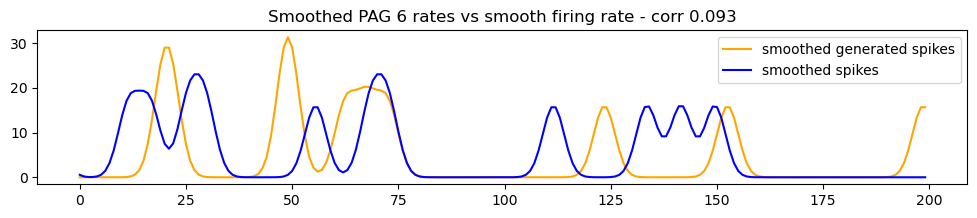

2023-12-05 11:56:34.458 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0
2023-12-05 11:56:34.653 | DEBUG    | glm:fit:269 - Training GLM with PyTorch. Initial log like: -202057.46875, inital loss: tensor([[202057.5156]])


Training on PAG # 7. Average PAG firing rate: 8.115277777777778e-05 Hz.


2023-12-05 11:58:35.391 | DEBUG    | glm:fit:299 - Training complete with best log like: -55777.8515625, best loss: tensor([[56176.1484]]) at epoch 10000.


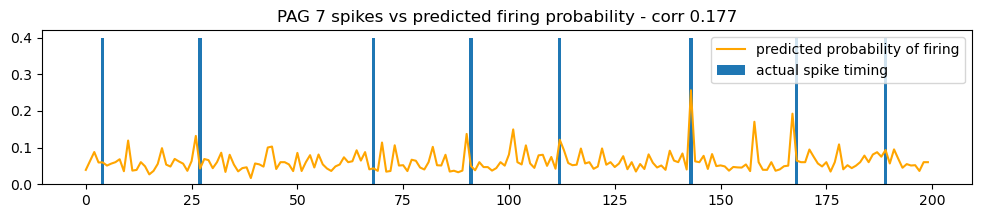

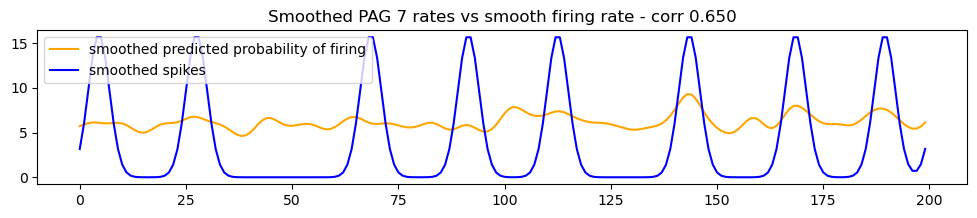

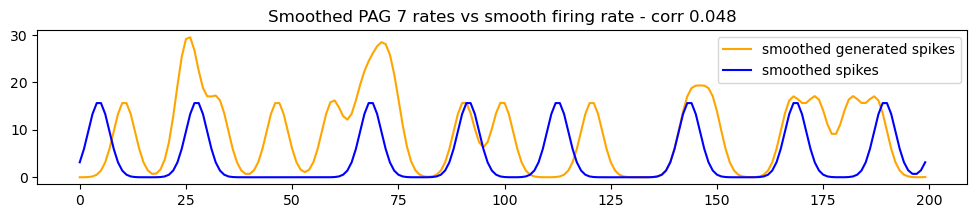

In [20]:
n_PAG_to_use = 1
n_input_neurons, n_bins = presyn_binned.shape
_total_length = n_bins / 1000
bin_size = 0.001


train_start = 0
train_end = 300
test_start = 300
test_end = 400
train_bins = int((train_end - train_start) / bin_size)
test_bins = int((test_end - test_start) / bin_size)

X_train, X_test = np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * train_bins)), np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * test_bins))
y_train, y_test = np.zeros((1, train_bins * n_PAG_to_use)), np.zeros((1, test_bins * n_PAG_to_use))

_range = 200 #ms
_random_start = np.random.randint(y_test.shape[1]-_range)

X_train[:n_input_neurons, :train_bins] = presyn_binned[:, int(train_start/bin_size):int(train_end/bin_size)]
X_test[:n_input_neurons, :test_bins] = presyn_binned[:, int(test_start/bin_size):int(test_end/bin_size)]

pag_df = extract_sim_as_df(sim_data_path, 'PAG')
pag_timings = extract_timings(pag_df, 'PAG')

for pag_i in range(8):
    pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[pag_i]
    print(f'Training on PAG # {pag_i}. Average PAG firing rate: {np.sum(pag_binned_spikes) / pag_binned_spikes.shape[0] / _total_length} Hz.')
    
    y_train[:,:train_bins] = pag_binned_spikes[int(train_start/bin_size): int(train_end/bin_size)]
    y_test[:,:test_bins] = pag_binned_spikes[int(test_start/bin_size): int(test_end/bin_size)]
    
    assert X_train.shape[1] == y_train.shape[1]
    assert X_test.shape[1] == y_test.shape[1]
    
    glm = BernoulliGLMPyTorch(
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    reg_params=1,
    ).to(device)

    glm.fit(X_train.T, y_train.T, n_iter=10000, lr=1e-3, verbose=0, decay=0.9998)
    glm.load_best_params()
    
    # test set prediction
    with torch.no_grad():
        y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)

    plt.figure(figsize=(12,2))
    plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
    plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
    plt.legend()
    plt.title(f'PAG {pag_i} spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
    plt.show()

    generated_spikes = generate_bernoulli_spikes(y_test_hat)

    smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
    smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
    smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

    plt.figure(figsize=(12,2))
    plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
    plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
    plt.legend()
    plt.title(f'Smoothed PAG {pag_i} rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
    plt.show()

    plt.figure(figsize=(12,2))
    plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
    plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
    plt.legend()
    plt.title(f'Smoothed PAG {pag_i} rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
    plt.show()

### multiple PAG cells with exponential prefiltering on inputs - this is to understand whether/ how much the pooling is helping

In [54]:
n_PAG_to_use = 8
sim_data_path = './sim/save/pagsim_w_stimuli/'
pre_convolve_spikes = True
bin_size = 0.001
brain_regions = [
                'VMH',
                'ACC',
                'IC',
                'SC',
                'PMD'
                ]

presyn_binned = np.load(sim_data_path+'presyn_binned.npy')
if pre_convolve_spikes:
    presyn_smooth = np.load(sim_data_path+'presyn_exp_smooth.npy')
    
n_input_neurons, n_bins = presyn_binned.shape
_total_length = n_bins / 1000

pag_df = extract_sim_as_df(sim_data_path, 'PAG')
pag_timings = extract_timings(pag_df, 'PAG')
if n_PAG_to_use == 1:
    pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[:n_PAG_to_use]
else:
    pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[:n_PAG_to_use]
print(f'Average PAG firing rate: {np.sum(pag_binned_spikes) / pag_binned_spikes.shape[0] / _total_length} Hz.')


2023-12-05 18:15:45.276 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Average PAG firing rate: 46.825208333333336 Hz.


In [55]:
# construct input and output matrices
train_start = 0
train_end = 300
test_start = 300
test_end = 400
# for pag_stim_w_stimuli, external pulses are delivered from 40 mins to 60 mins, 10 secs each, lasting 1 sec
train_bins = int((train_end - train_start) / bin_size)
test_bins = int((test_end - test_start) / bin_size)

X_train, X_test = np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * train_bins)), np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * test_bins))
y_train, y_test = np.zeros((1, train_bins * n_PAG_to_use)), np.zeros((1, test_bins * n_PAG_to_use))

print(X_train.shape)
for n in range(n_PAG_to_use):
    X_train[n_input_neurons*n:n_input_neurons*(n+1), n * train_bins: (n+1) * train_bins] = presyn_smooth[:, int(train_start/bin_size):int(train_end/bin_size)] # chunks of n_neurons * train_set_bin_size
    X_test[n_input_neurons*n:n_input_neurons*(n+1), n * test_bins :(n+1) * test_bins] = presyn_smooth[:, int(test_start/bin_size):int(test_end/bin_size)]
    
    y_train[:, n * train_bins: (n+1)* train_bins] = pag_binned_spikes[n, int(train_start/bin_size): int(train_end/bin_size)]
    y_test[:, n * test_bins: (n+1)* test_bins] = pag_binned_spikes[n, int(test_start/bin_size): int(test_end/bin_size)]
assert X_train.shape[1] == y_train.shape[1]
assert X_test.shape[1] == y_test.shape[1]

print('Number of PAG spikes in the training set: ', np.sum(y_train))
print('Number of PAG spikes in the test set: ', np.sum(y_test))

(2560, 2400000)
Number of PAG spikes in the training set:  112056.0
Number of PAG spikes in the test set:  37146.0


In [ ]:
glm = BernoulliGLMPyTorch(
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    reg_params=1,
    ).to(device)

glm.fit(X_train.T, y_train.T, n_iter=10000, lr=1e-3, verbose=1, decay=0.9998)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}mult_exp_reg1.pth')
# glm._load_state_dict(torch.load(f'{sim_data_path}mult_exp_reg1.pth'))

2023-12-05 18:16:14.950 | DEBUG    | glm:fit:269 - Training GLM with PyTorch. Initial log like: -1643761.5, inital loss: tensor([[1643761.5000]])


#### Analysis

In [99]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)

Learned bias: [-0.2257707]


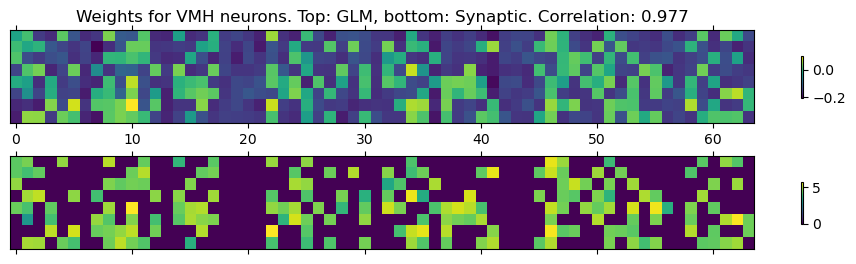

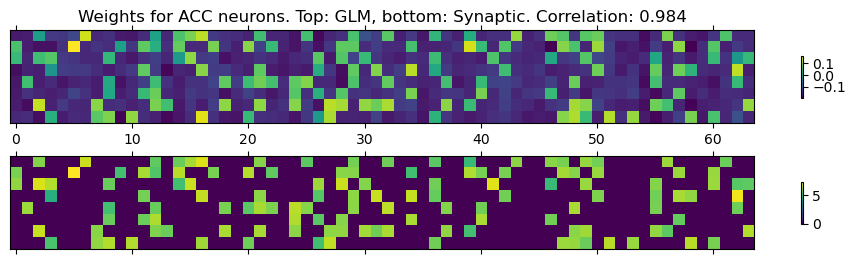

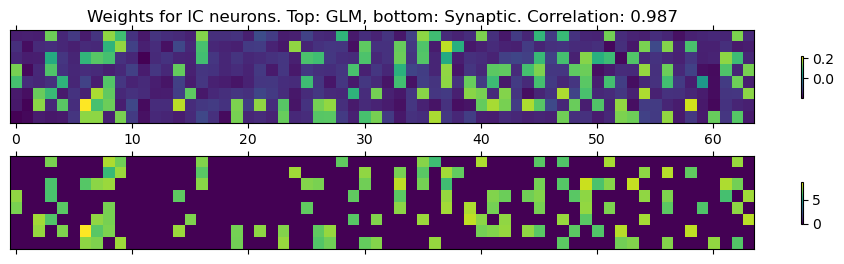

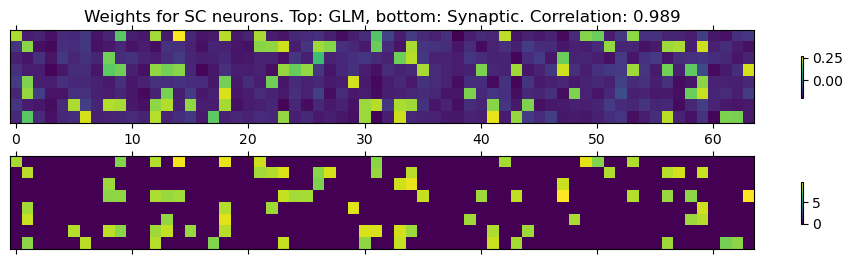

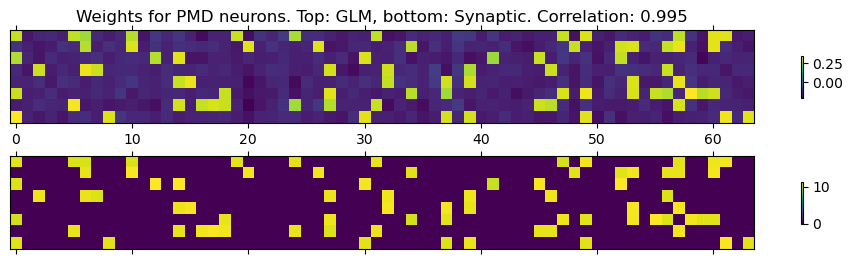

In [100]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_neuron_idx[m]], conns[m, :n_PAG_to_use, :].flatten())[0,1]
    
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,3))
    mat1 = axes[0].matshow(glm_w[..., glm.group_neuron_idx[m]].reshape(n_PAG_to_use, -1))
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])

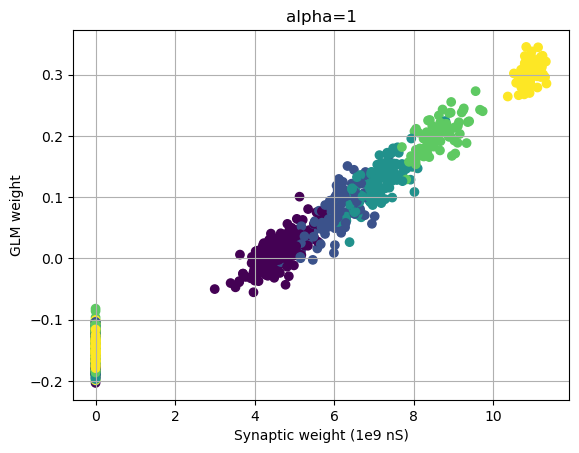

In [102]:
plt.scatter(conns[:,:n_PAG_to_use,:].transpose(1,0,2).flatten(), glm_w, c=glm.neuron_group_idx)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.title('alpha=1')
plt.show()

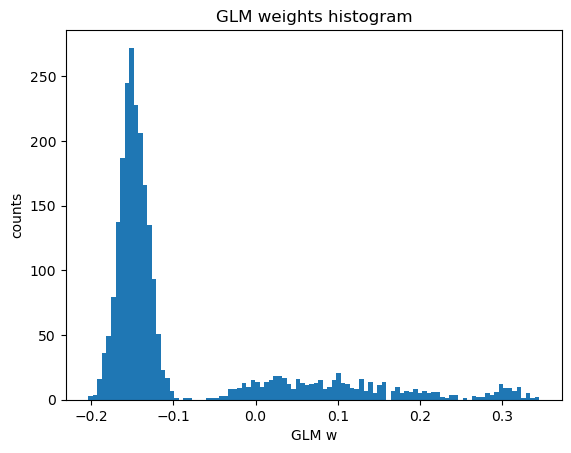

In [30]:
plt.hist(glm_w[0], bins=100);
plt.xlabel('GLM w')
plt.ylabel('counts')
plt.title('GLM weights histogram')
plt.show()

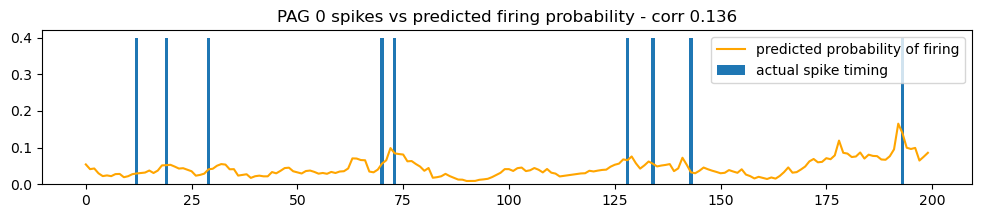

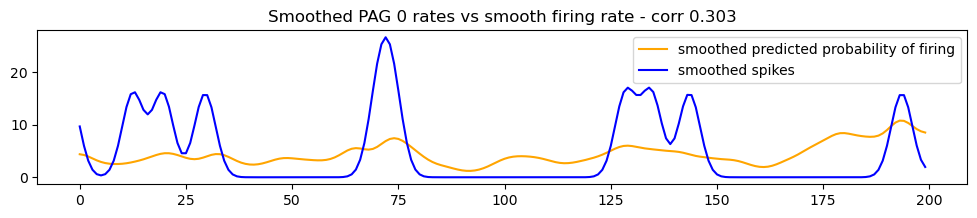

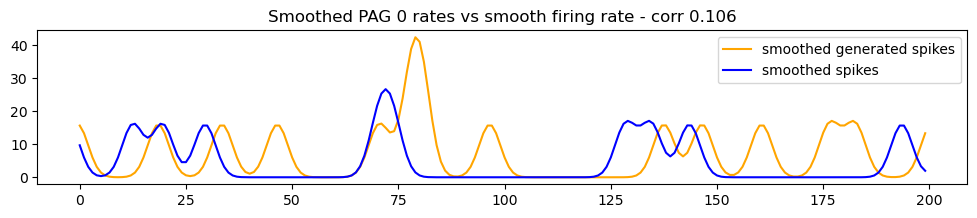

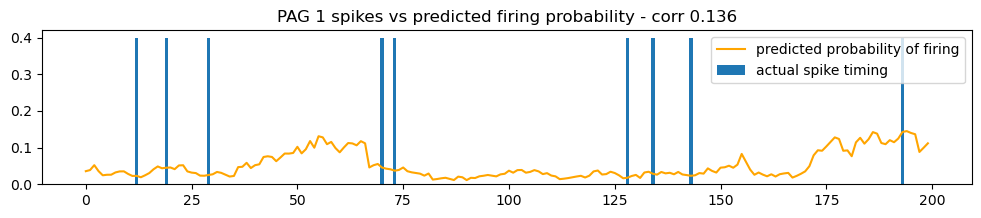

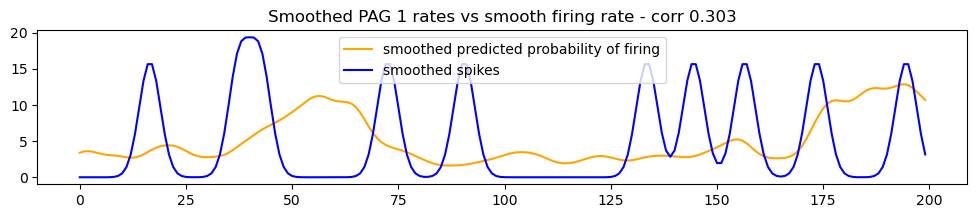

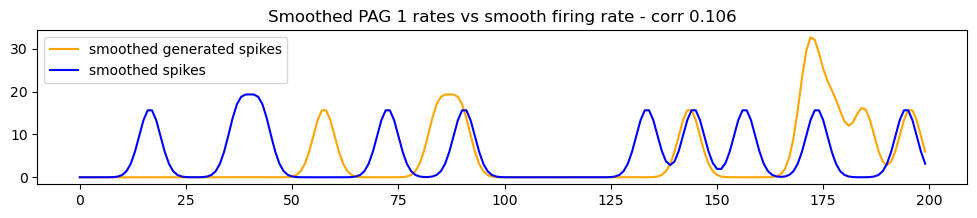

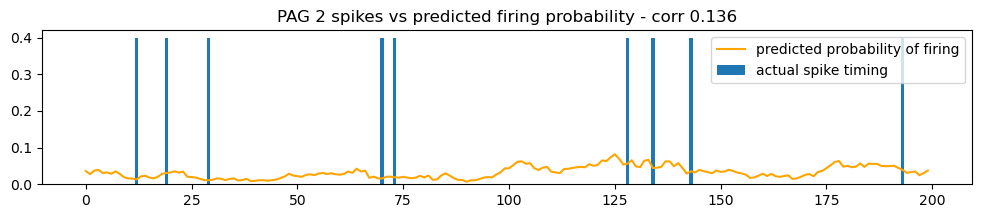

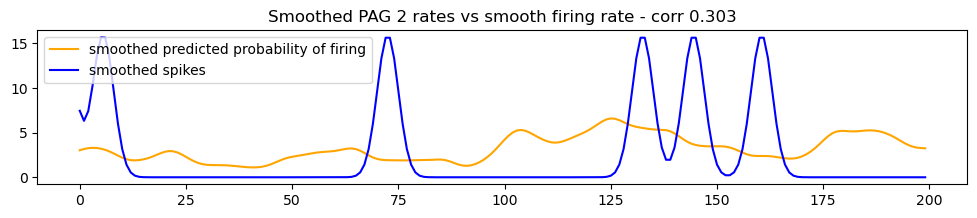

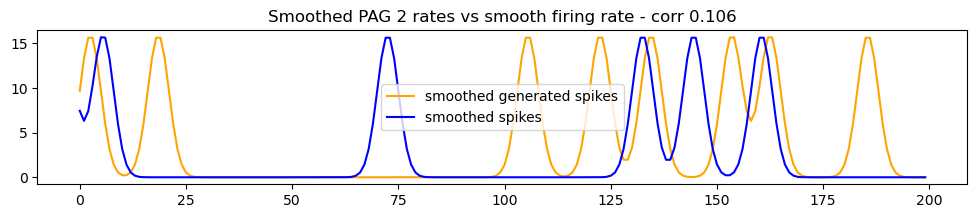

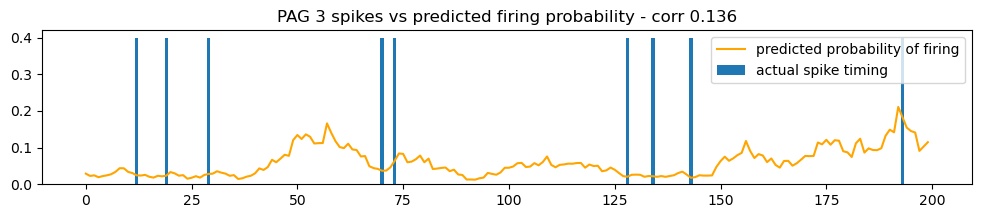

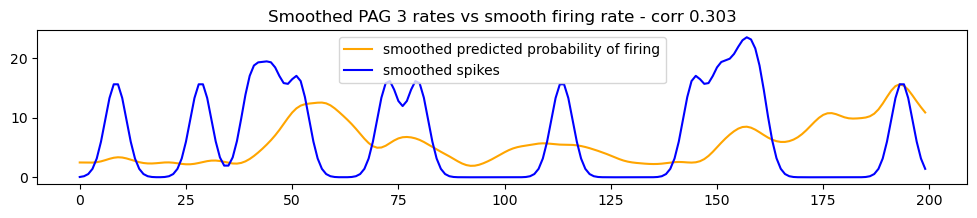

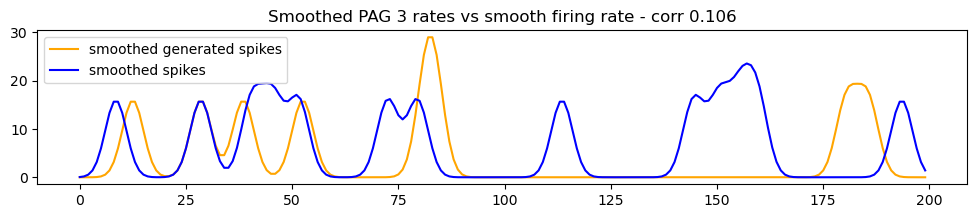

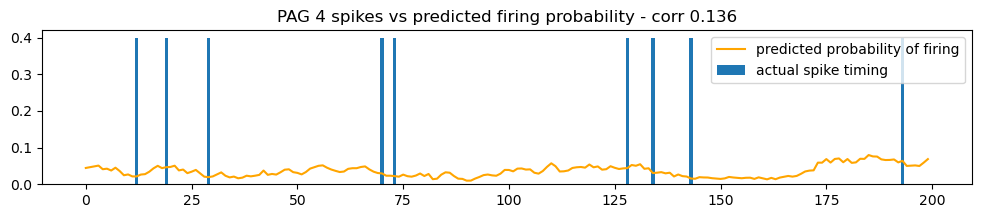

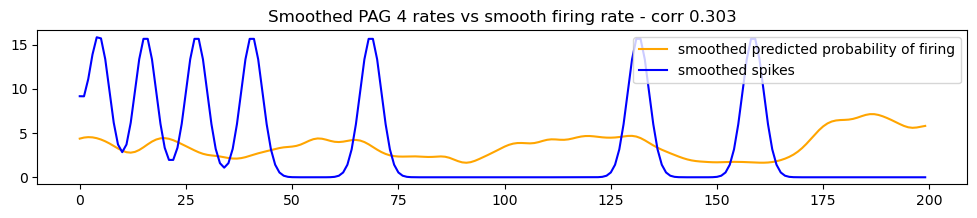

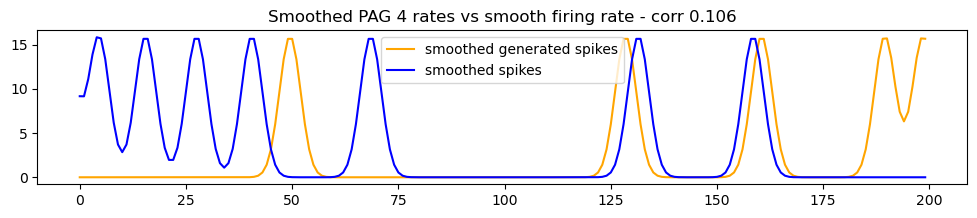

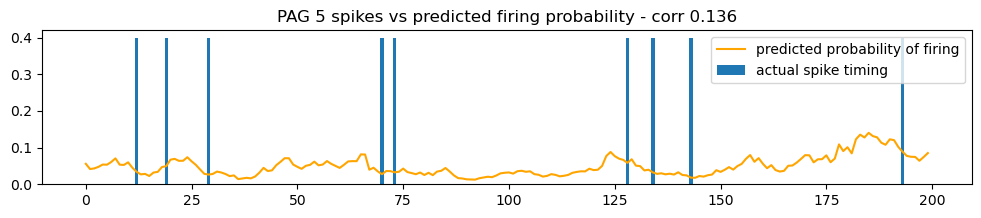

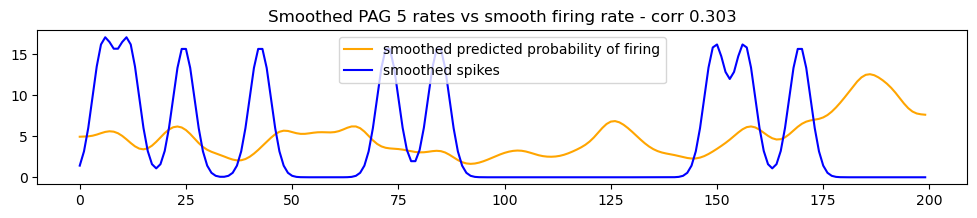

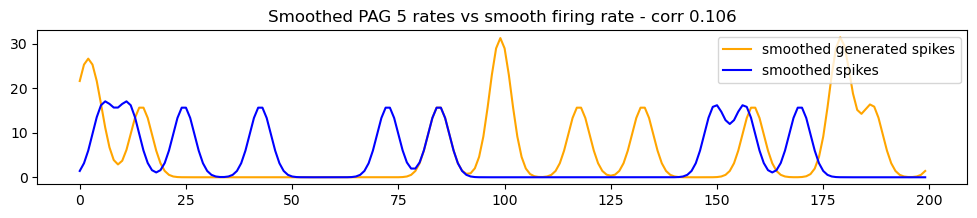

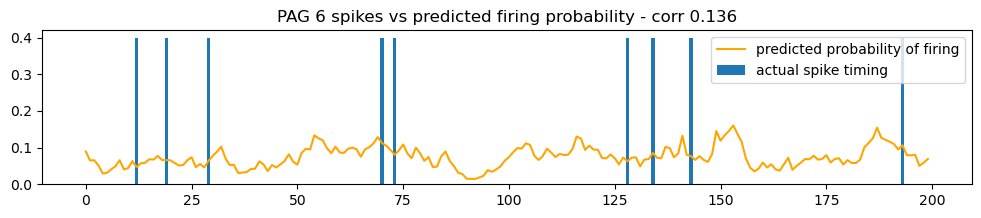

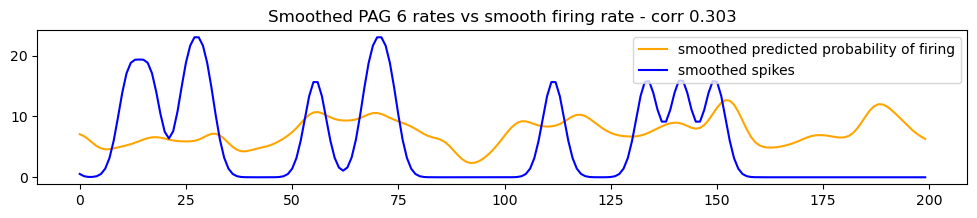

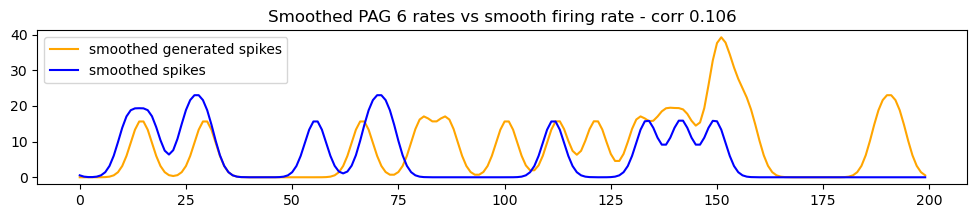

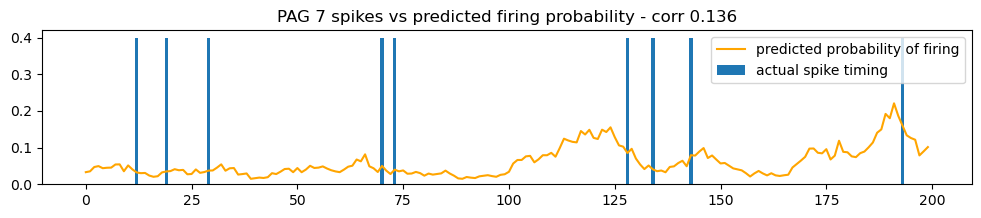

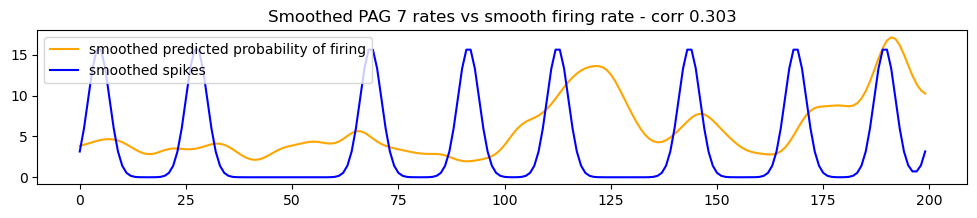

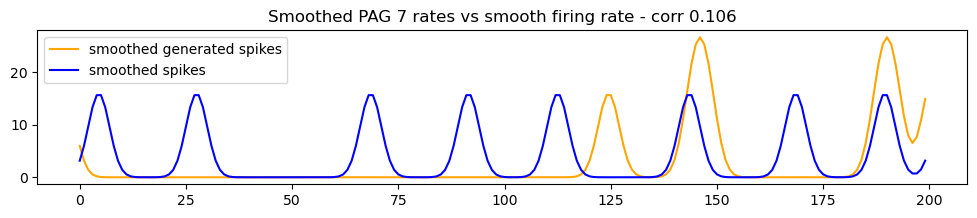

In [34]:
# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)


generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

for pag_i in range(n_PAG_to_use):
    
    plt.figure(figsize=(12,2))
    plt.plot(y_test_hat.cpu()[0, pag_i*test_bins + _random_start: pag_i*test_bins + _random_start + _range], label='predicted probability of firing', color='orange')
    plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
    plt.legend()
    plt.title(f'PAG {pag_i} spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
    plt.show()

    plt.figure(figsize=(12,2))
    plt.plot(smooth_y_test_hat[pag_i*test_bins + _random_start: pag_i*test_bins + _random_start + _range], label='smoothed predicted probability of firing', color='orange')
    plt.plot(smooth_y_test[pag_i*test_bins + _random_start: pag_i*test_bins + _random_start + _range], label='smoothed spikes', color='blue')
    plt.legend()
    plt.title(f'Smoothed PAG {pag_i} rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
    plt.show()

    plt.figure(figsize=(12,2))
    plt.plot(smooth_y_test_hat_generated_spikes[pag_i*test_bins + _random_start: pag_i*test_bins + _random_start + _range], label='smoothed generated spikes', color='orange')
    plt.plot(smooth_y_test[pag_i*test_bins + _random_start: pag_i*test_bins + _random_start + _range], label='smoothed spikes', color='blue')
    plt.legend()
    plt.title(f'Smoothed PAG {pag_i} rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
    plt.show()


In [31]:
test_bins

100000

In [34]:
y_test_hat.shape

torch.Size([1, 800000])

### multiple PAG cells with exponential prefiltering on inputs, run at different alphas - 0 vs 0.5 vs 1 vs 10 (note: i assumed your default lambda is 1, feel free to correct if wrong)

### alpha = 0.1

In [21]:
n_PAG_to_use = 8
glm = BernoulliGLMPyTorch(
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    reg_params=0.1,
    ).to(device)

# glm.fit(X_train.T, y_train.T, n_iter=2000, lr=1e-3, verbose=1, decay=0.9998)
# glm.load_best_params()
# torch.save(glm.state_dict(), f'{sim_data_path}mult_exp_reg_01.pth')
glm._load_state_dict(torch.load(f'{sim_data_path}mult_exp_reg_01.pth'))

#### Analysis

Learned bias: [-0.20139375]


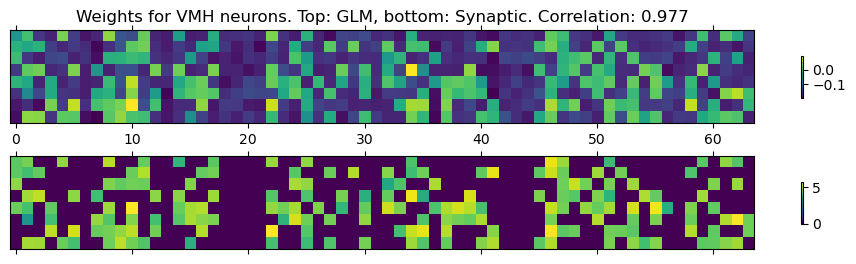

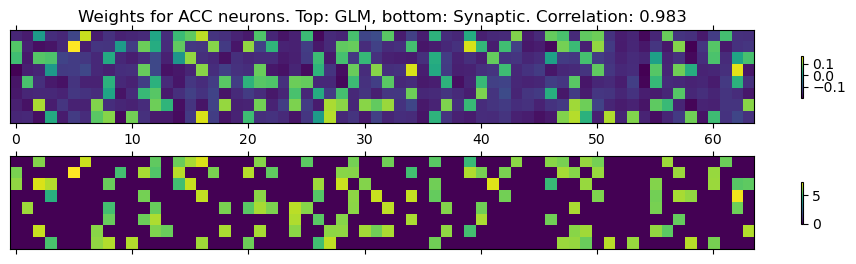

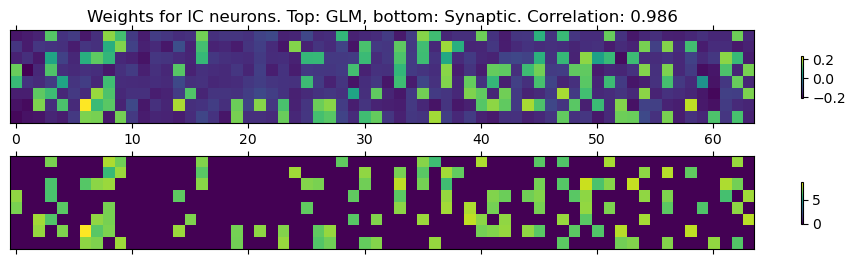

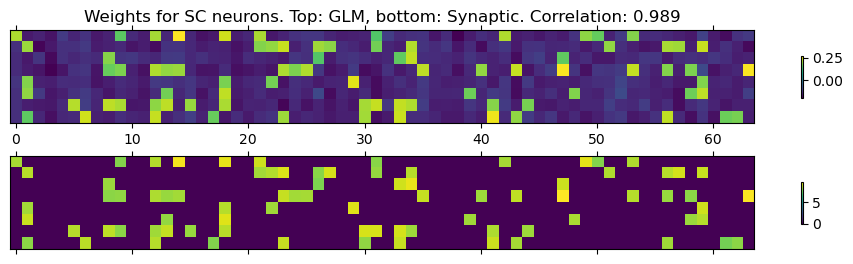

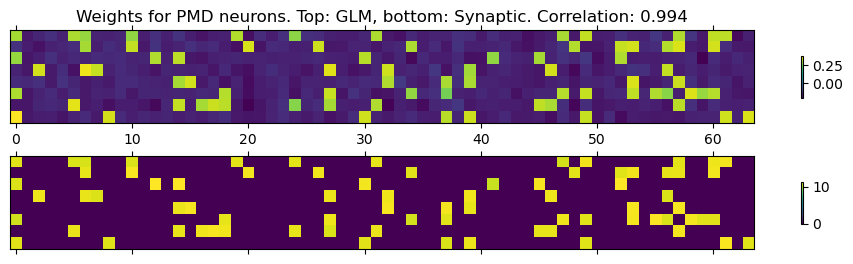

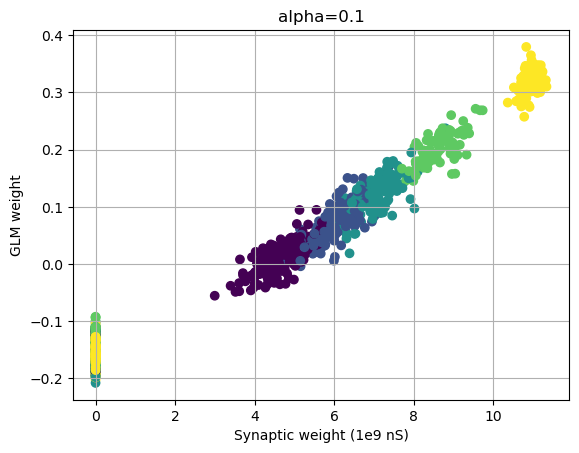

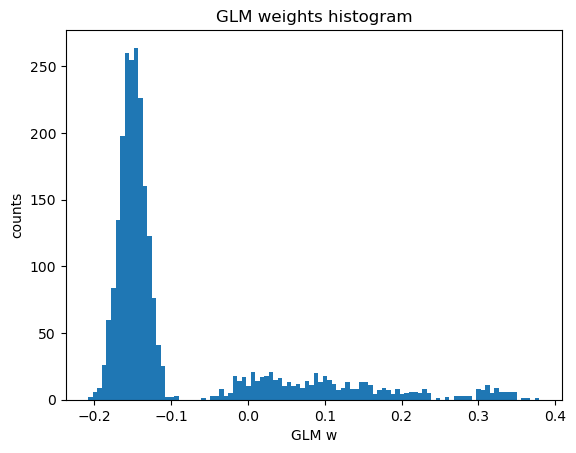

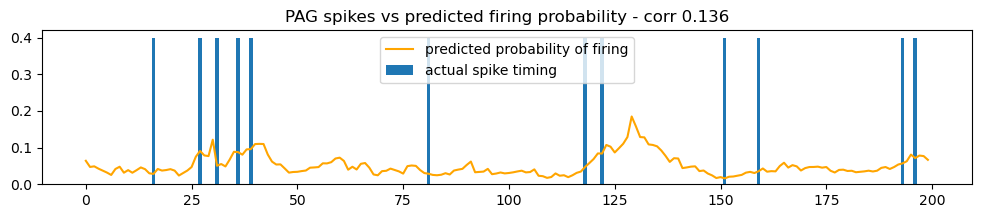

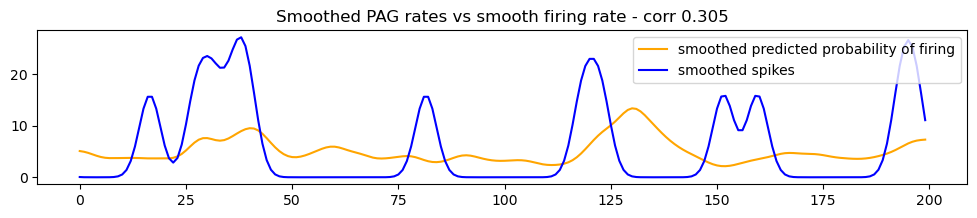

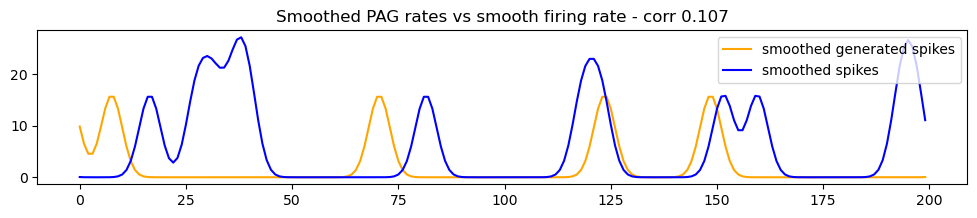

In [93]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)

# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_neuron_idx[m]], conns[m, :n_PAG_to_use, :].flatten())[0,1]
    
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,3))
    mat1 = axes[0].matshow(glm_w[..., glm.group_neuron_idx[m]].reshape(n_PAG_to_use, -1))
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

plt.scatter(conns[:,:n_PAG_to_use,:].transpose(1,0,2).flatten(), glm_w, c=glm.neuron_group_idx)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.title('alpha=0.1')
plt.show()

plt.hist(glm_w[0], bins=100);
plt.xlabel('GLM w')
plt.ylabel('counts')
plt.title('GLM weights histogram')
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    
# _range = 200 #ms
# _random_start = np.random.randint(y_test.shape[1]-_range)

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()



generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

In [116]:
torch.nn.functional.sigmoid(torch.tensor([-0.226]))

tensor([0.4437])

### alpha = 10

In [90]:
glm = BernoulliGLMPyTorch(
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    reg_params=10,
    ).to(device)

# glm.fit(X_train.T, y_train.T, n_iter=2000, lr=1e-3, verbose=1, decay=0.9998)
# glm.load_best_params()
# torch.save(glm.state_dict(), f'{sim_data_path}mult_exp_reg_10.pth')
glm._load_state_dict(torch.load(f'{sim_data_path}mult_exp_reg_10.pth'))

#### Analysis

Learned bias: [-0.22780022]


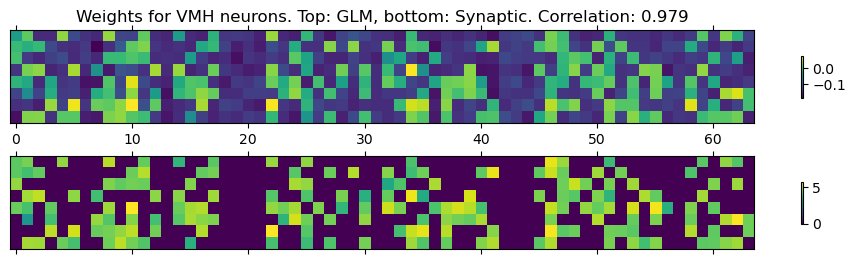

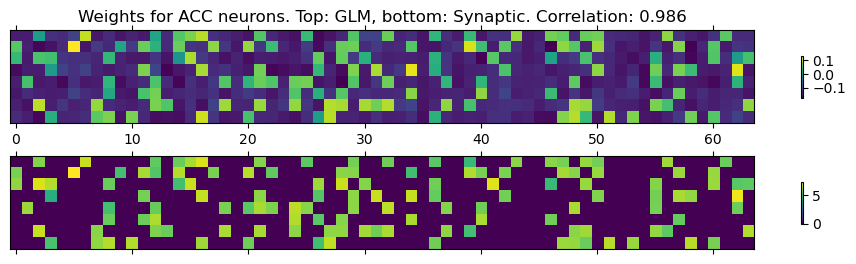

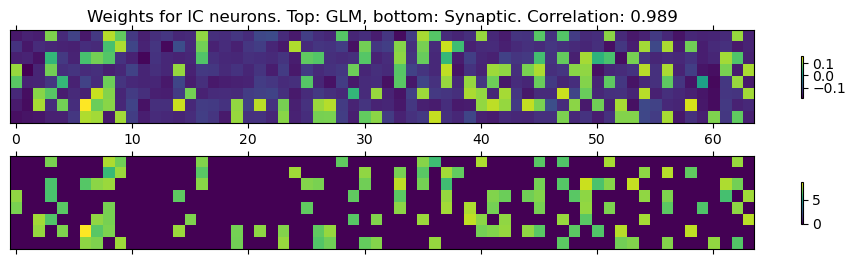

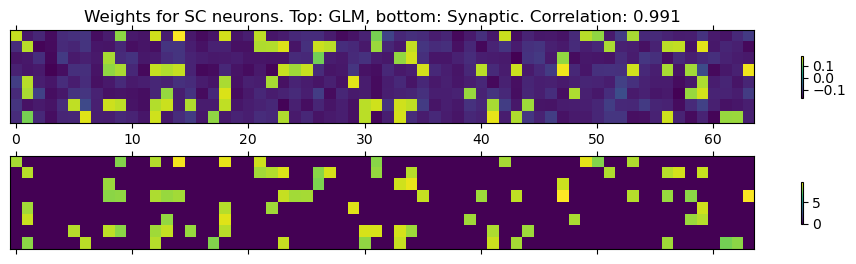

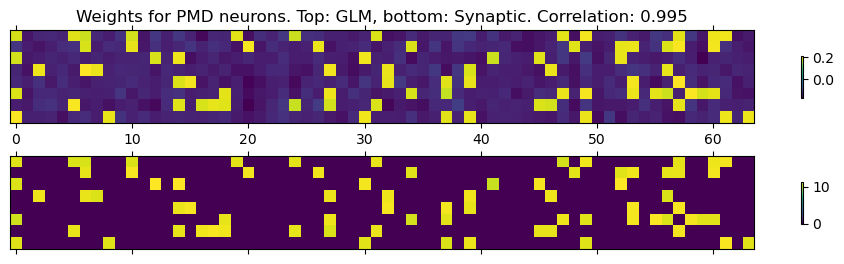

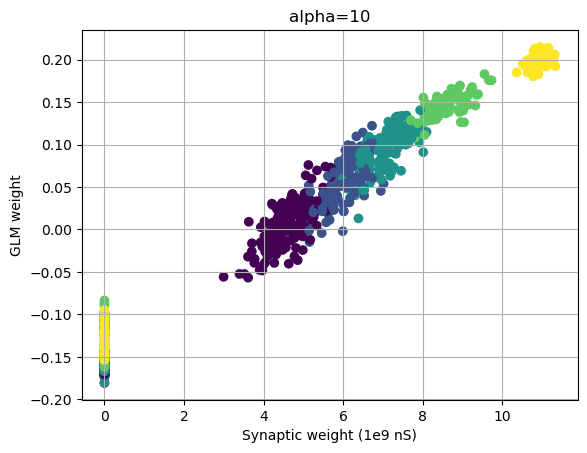

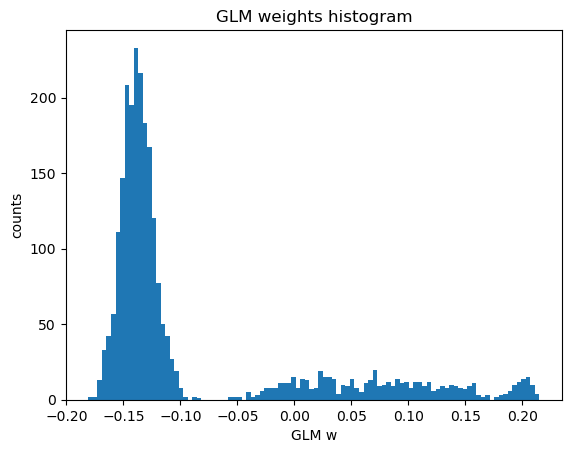

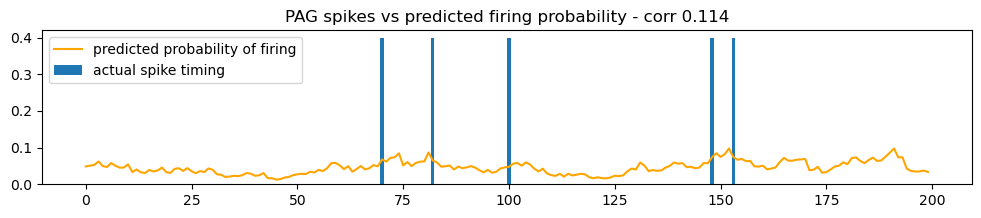

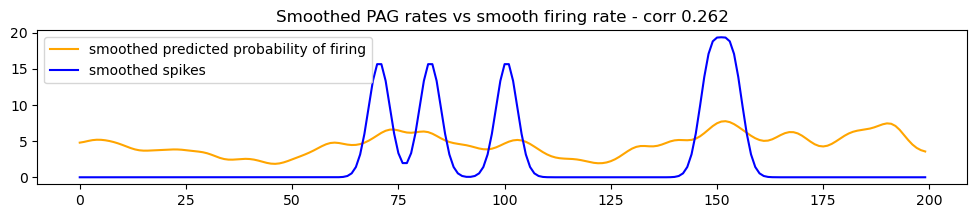

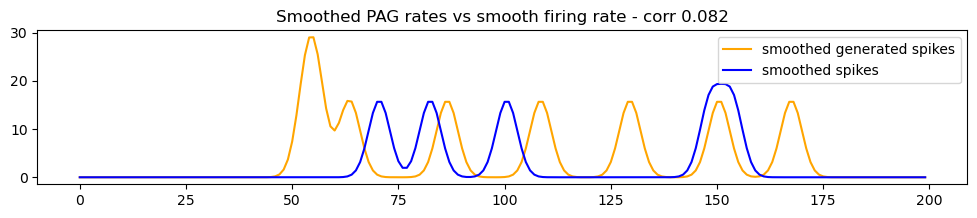

In [91]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)

# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_neuron_idx[m]], conns[m, :n_PAG_to_use, :].flatten())[0,1]
    
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,3))
    mat1 = axes[0].matshow(glm_w[..., glm.group_neuron_idx[m]].reshape(n_PAG_to_use, -1))
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

plt.scatter(conns[:,:n_PAG_to_use,:].transpose(1,0,2).flatten(), glm_w, c=glm.neuron_group_idx)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.title('alpha=10')
plt.show()

plt.hist(glm_w[0], bins=100);
plt.xlabel('GLM w')
plt.ylabel('counts')
plt.title('GLM weights histogram')
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()



generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

### alpha = 100

In [94]:
glm = BernoulliGLMPyTorch(
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    reg_params=100,
    ).to(device)

# glm.fit(X_train.T, y_train.T, n_iter=2000, lr=1e-3, verbose=1, decay=0.9998)
# glm.load_best_params()
# torch.save(glm.state_dict(), f'{sim_data_path}mult_exp_reg_100.pth')
glm._load_state_dict(torch.load(f'{sim_data_path}mult_exp_reg_100.pth'))

#### Analysis

Learned bias: [-0.22205198]


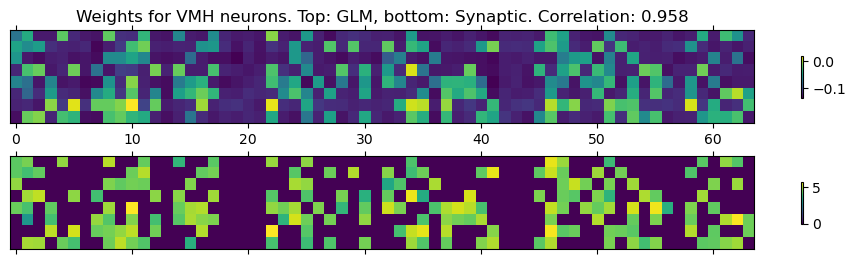

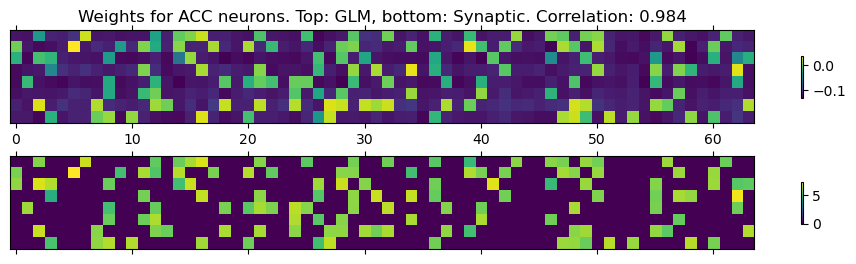

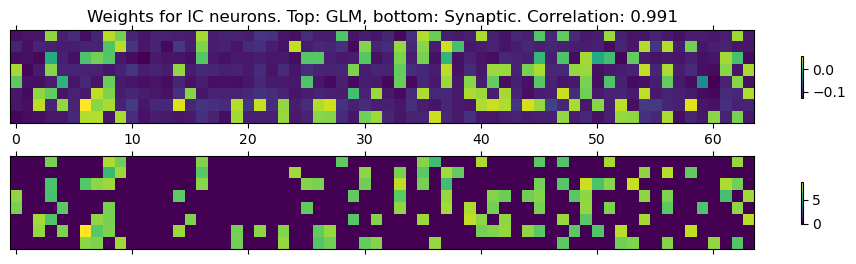

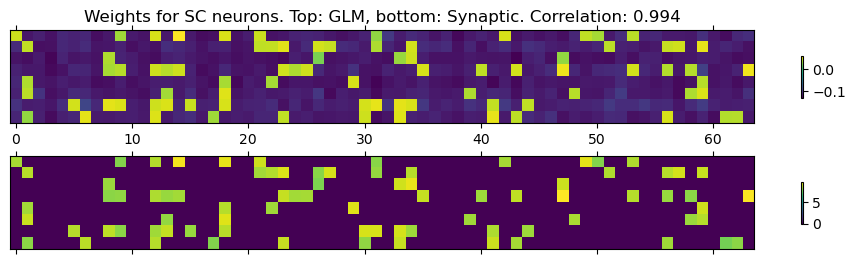

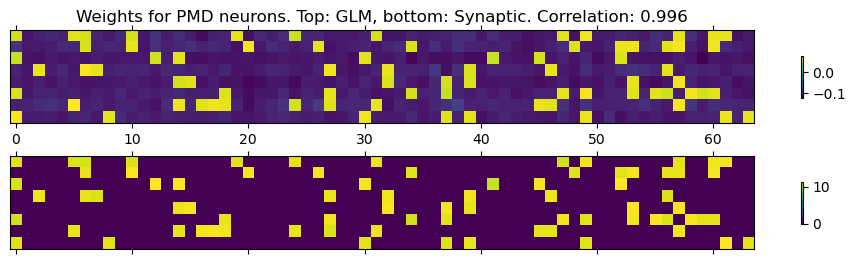

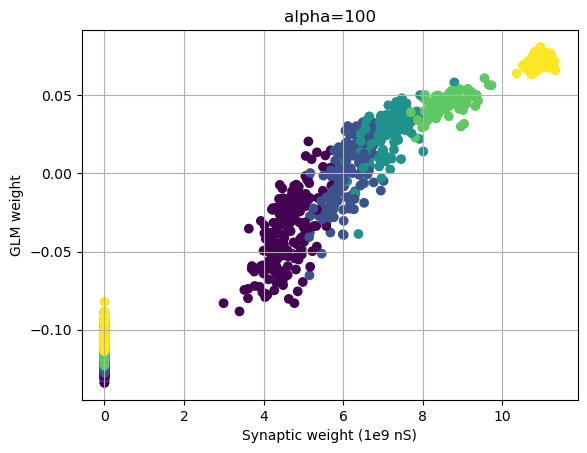

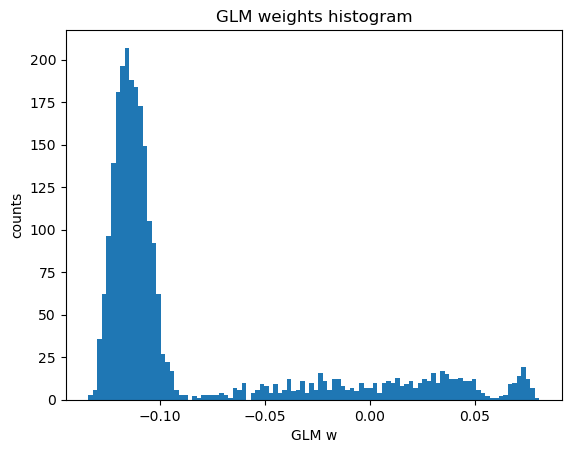

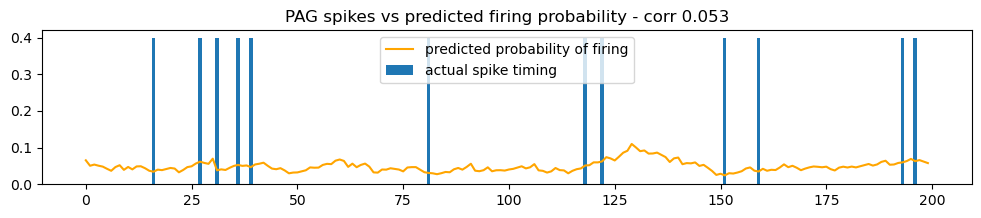

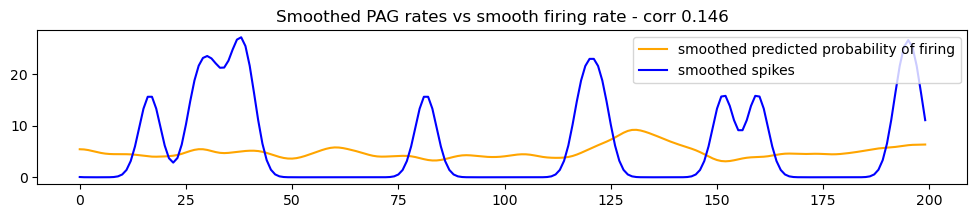

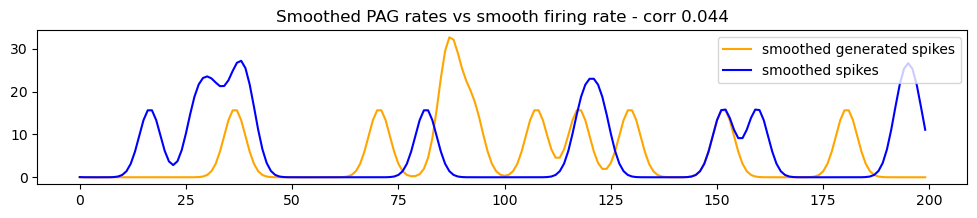

In [95]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)

# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_neuron_idx[m]], conns[m, :n_PAG_to_use, :].flatten())[0,1]
    
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,3))
    mat1 = axes[0].matshow(glm_w[..., glm.group_neuron_idx[m]].reshape(n_PAG_to_use, -1))
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

plt.scatter(conns[:,:n_PAG_to_use,:].transpose(1,0,2).flatten(), glm_w, c=glm.neuron_group_idx)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.title('alpha=100')
plt.show()

plt.hist(glm_w[0], bins=100);
plt.xlabel('GLM w')
plt.ylabel('counts')
plt.title('GLM weights histogram')
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

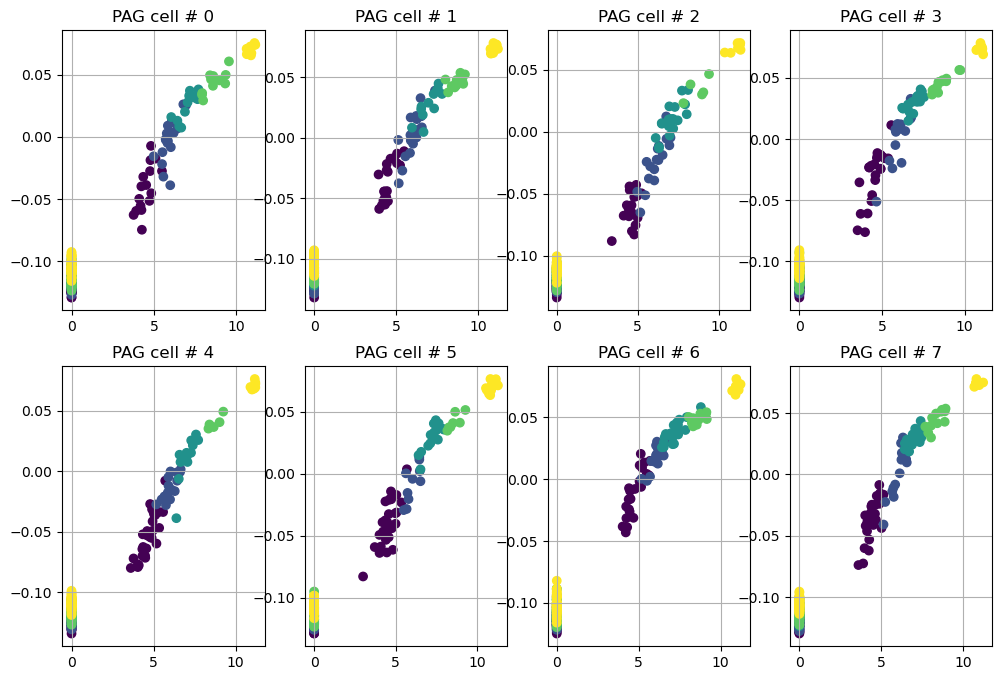

In [78]:
plt.subplots(2, 4, figsize=(12,8))
for pag_i in range(n_PAG_to_use):
    plt.subplot(2, 4, pag_i+1)
    plt.scatter(conns[:,pag_i,:].flatten(), glm_w[0, pag_i*320:(pag_i+1)*320], c=glm.neuron_group_idx[ pag_i*320:(pag_i+1)*320])
    
    plt.grid()
    plt.title(f'PAG cell # {pag_i}')
plt.show()

### multiple PAG cells with exponential prefiltering on inputs, excluding at random 25% of their respective connected cells from their input (note: 25% is an arbitrary number) - this is to see how the model fares when we mimic not being able to record from all the connected inputs

In [47]:
n_PAG_to_use = 8
sim_data_path = './sim/save/pagsim_w_stimuli/'
pre_convolve_spikes = True
bin_size = 0.001
brain_regions = [
                'VMH',
                'ACC',
                'IC',
                'SC',
                'PMD'
                ]

presyn_binned = np.load(sim_data_path+'presyn_binned.npy')
if pre_convolve_spikes:
    presyn_smooth = np.load(sim_data_path+'presyn_exp_smooth.npy')
    
n_input_neurons, n_bins = presyn_binned.shape
_total_length = n_bins / 1000

pag_df = extract_sim_as_df(sim_data_path, 'PAG')
pag_timings = extract_timings(pag_df, 'PAG')
if n_PAG_to_use == 1:
    pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[:n_PAG_to_use]
else:
    pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[:n_PAG_to_use]
print(f'Average PAG firing rate: {np.sum(pag_binned_spikes) / pag_binned_spikes.shape[0] / _total_length} Hz.')


2023-12-05 18:08:12.585 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Average PAG firing rate: 46.825208333333336 Hz.


In [50]:
# construct input and output matrices
train_start = 0
train_end = 300
test_start = 300
test_end = 400
# for pag_stim_w_stimuli, external pulses are delivered from 40 mins to 60 mins, 10 secs each, lasting 1 sec
train_bins = int((train_end - train_start) / bin_size)
test_bins = int((test_end - test_start) / bin_size)

# implement random dropout - 25% neurons are unobserved
random_drop_rate = 0.50
bernoulli_mask = np.random.binomial(n=1, p=1-random_drop_rate, size=(5,64))

np.save(f'{sim_data_path}mult_exp_dropout_reg1_mask{str(random_drop_rate)[2:]}.npy', bernoulli_mask)

input_neurons_idx = list(np.where(bernoulli_mask.flatten() == 1)[0])
n_input_neurons = np.sum(bernoulli_mask)

X_train, X_test = np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * train_bins)), np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * test_bins))
y_train, y_test = np.zeros((1, train_bins * n_PAG_to_use)), np.zeros((1, test_bins * n_PAG_to_use))

print(X_train.shape)
for n in range(n_PAG_to_use):
    X_train[n_input_neurons*n:n_input_neurons*(n+1), n * train_bins: (n+1) * train_bins] = presyn_smooth[input_neurons_idx, int(train_start/bin_size):int(train_end/bin_size)] # chunks of n_neurons * train_set_bin_size
    X_test[n_input_neurons*n:n_input_neurons*(n+1), n * test_bins :(n+1) * test_bins] = presyn_smooth[input_neurons_idx, int(test_start/bin_size):int(test_end/bin_size)]
    
    y_train[:, n * train_bins: (n+1)* train_bins] = pag_binned_spikes[n, int(train_start/bin_size): int(train_end/bin_size)]
    y_test[:, n * test_bins: (n+1)* test_bins] = pag_binned_spikes[n, int(test_start/bin_size): int(test_end/bin_size)]
assert X_train.shape[1] == y_train.shape[1]
assert X_test.shape[1] == y_test.shape[1]

print('Number of PAG spikes in the training set: ', np.sum(y_train))
print('Number of PAG spikes in the test set: ', np.sum(y_test))

(1216, 2400000)
Number of PAG spikes in the training set:  112056.0
Number of PAG spikes in the test set:  37146.0


In [52]:
glm = BernoulliGLMPyTorch(
    n_neurons_per_group=np.sum(bernoulli_mask, axis=1),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    reg_params=1,
    ).to(device)

glm.fit(X_train.T, y_train.T, n_iter=4000, lr=1e-3, verbose=1, decay=0.9998)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}mult_exp_dropout_reg1.pth')

# glm._load_state_dict(torch.load(f'{sim_data_path}mult_exp_dropout_reg1.pth'))
# bernoulli_mask = np.load(f'{sim_data_path}mult_exp_dropout_reg1_mask25.npy')

2023-12-05 18:09:53.409 | DEBUG    | glm:fit:269 - Training GLM with PyTorch. Initial log like: -1689368.25, inital loss: tensor([[1689368.1250]])
2023-12-05 18:10:14.332 | DEBUG    | glm:fit:289 - Step 200. Log like: -550002.875,  loss: 550005.4375
2023-12-05 18:10:31.693 | DEBUG    | glm:fit:289 - Step 400. Log like: -487351.125,  loss: 487356.625
2023-12-05 18:10:49.139 | DEBUG    | glm:fit:289 - Step 600. Log like: -479092.75,  loss: 479103.03125
2023-12-05 18:11:06.570 | DEBUG    | glm:fit:289 - Step 800. Log like: -476177.0,  loss: 476194.3125
2023-12-05 18:11:25.483 | DEBUG    | glm:fit:289 - Step 1000. Log like: -473810.75,  loss: 473837.71875
2023-12-05 18:11:44.650 | DEBUG    | glm:fit:289 - Step 1200. Log like: -471468.4375,  loss: 471508.625
2023-12-05 18:12:02.788 | DEBUG    | glm:fit:289 - Step 1400. Log like: -469130.1875,  loss: 469189.09375
2023-12-05 18:12:20.175 | DEBUG    | glm:fit:289 - Step 1600. Log like: -466832.5,  loss: 466918.25
2023-12-05 18:12:37.082 | DEBU

#### Analysis

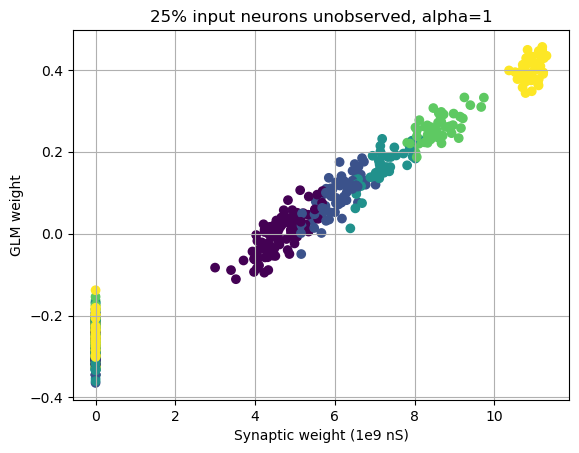

In [53]:
# plot lesioned weights vs non-lesioned weights
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy()

plt.scatter(conns[:,:n_PAG_to_use,:].transpose(1,0,2).reshape(-1, 320)[...,input_neurons_idx].flatten(), glm_w, c=glm.neuron_group_idx)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.title('25% input neurons unobserved, alpha=1')
plt.show()

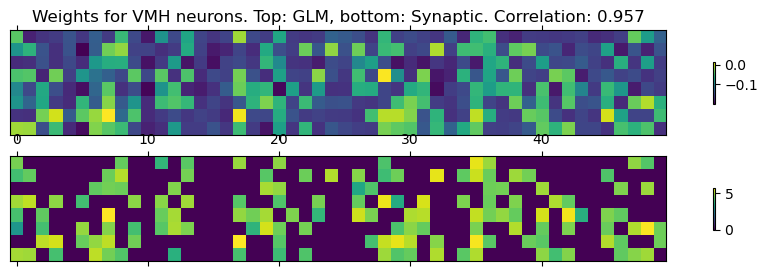

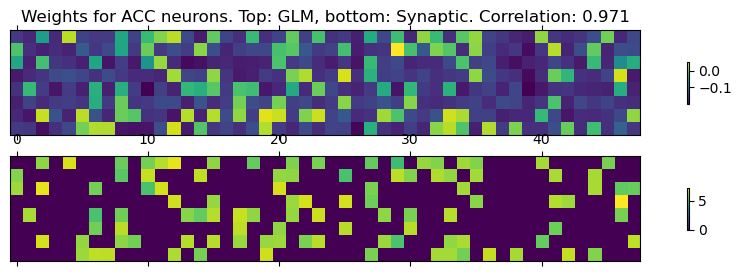

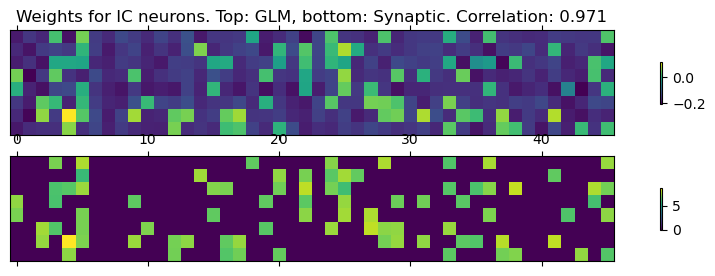

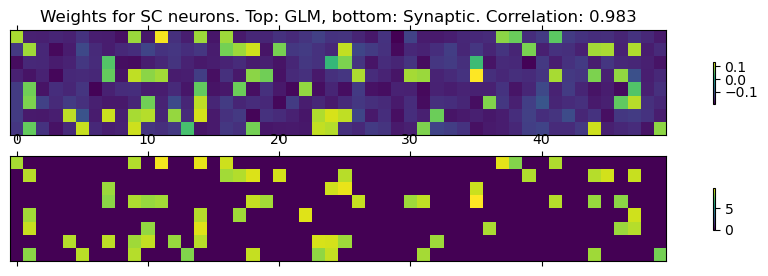

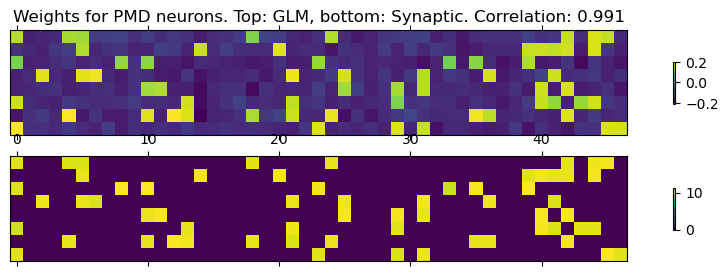

In [42]:
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_neuron_idx[m]], conns[m, :n_PAG_to_use, list(np.where(bernoulli_mask[m]==1)[0])].T.flatten())[0,1]
    
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,3))
    
    mat1 = axes[0].matshow(glm_w[..., glm.group_neuron_idx[m]].reshape(n_PAG_to_use, -1))
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, list(np.where(bernoulli_mask[m]==1)[0])].T)
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

In [32]:
np.where(bernoulli_mask[m]==1)[0]

array([ 1,  2,  3,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 37, 39, 41, 42,
       45, 46, 47, 49, 50, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63],
      dtype=int64)

### multiple PAG cells with exponential prefiltering on inputs, but now with the inputs all drawn from the same gaussian distribution rather than separate ones. possibly also run at the different alphas as in 4) - this is to test what happens if our assumption that the underlying connectivity is based on separate gaussian distributions is false
